In [1]:
import data
import models
import cache
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
from matplotlib import pyplot as plt
%matplotlib inline

/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import logging
cache_logger = logging.getLogger('cache')
cache_logger.setLevel(logging.DEBUG)

In [3]:
sns.set(context='talk')

In [4]:
by = 'cell_type'
sample_n = 500
model_name = 'model4'

## load data for a sample of genes

In [5]:
sample_df = cache.cached(models.prep_sample_df, sample_n=sample_n)

DEBUG:cache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_31194724242.pkl
DEBUG:cache:prep_sample_df: cache_filepath set to /home/jacquelineburos/projects/immune-infiltrate-explorations/behavior_of_rnaseq_data/.cached_models/prep_sample_df.cached.sample_n_31194724242.pkl
INFO:cache:prep_sample_df: Loading result from cache


## fit model

In [6]:
stan_data = models.prep_stan_data(sample_df, by=by)

In [7]:
model_file = models.get_model_file(model_name='model4')
print(cache._read_file(model_file))

## try neg binom parameterization
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     // note: classes should be mutually exclusive. Each row here should sum to 1
   
    // data
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
}
transformed data {
    int sample_y[S, G]; // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample_y[sample[n], gene[n]] = y[n];
        sample_x[sample[n]] = x[n,];
    }
}
parameters {
    matrix<lower=0>[G, C] theta; // loading factors for each gene, for each cell type
    vector[G] log_gene_base;

In [8]:
model_fit = models.cached_stan_fit(file=model_file, data=stan_data, iter=500, chains=4, model_name=model_name)

INFO:cache:Step 1: Get compiled model code, possibly from cache
DEBUG:cache:StanModel: cache_filename set to model4.model_code_35447780597.stanmodel.pkl
DEBUG:cache:StanModel: cache_filepath set to /home/jacquelineburos/projects/immune-infiltrate-explorations/behavior_of_rnaseq_data/.cached_models/model4.model_code_35447780597.stanmodel.pkl
INFO:cache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL model4_d09e80854e7f93b664ec488b3c4b8b08 NOW.
INFO:cache:StanModel: Execution completed (0:01:03.981014 elapsed)
INFO:cache:StanModel: Saving results to cache
INFO:cache:Step 2: Get posterior draws from model, possibly from cache
DEBUG:cache:sampling: cache_filename set to model4.model_code_35447780597.stanfit.chains_81232192355.data_35729880489.iter_31194724242.seed_57902074806.pkl
DEBUG:cache:sampling: cache_filepath set to /home/jacquelineburos/projects/immune-infiltrate-explorations/behavior_of_rnaseq_data/.cached_models/model4.model_code_35447780597.stanfit.cha

## check convergence (superficially)

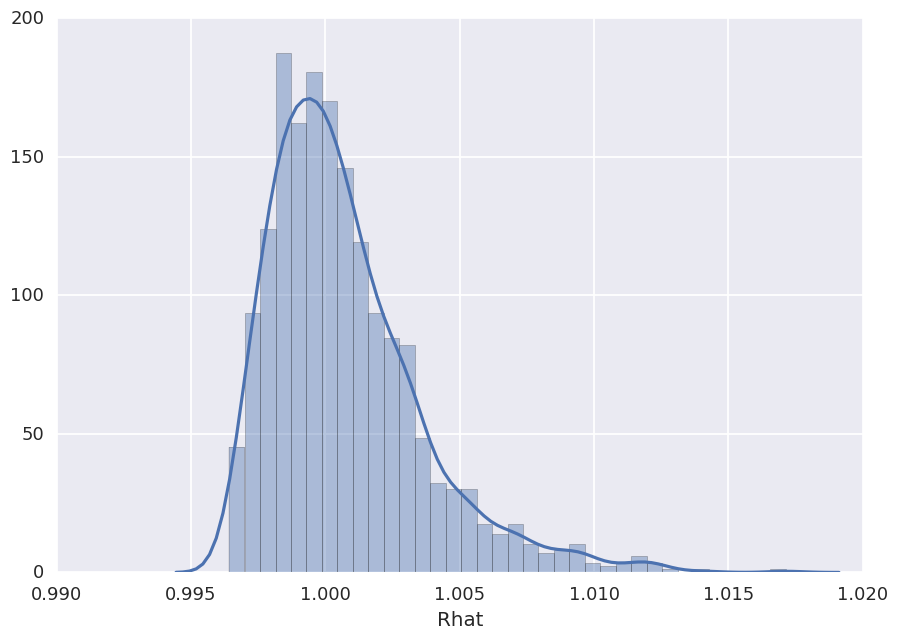

In [9]:
models.plot_stan_summary(model_fit, pars='theta', metric='Rhat')

In [10]:
models.print_stan_summary(model_fit, pars='lp__')

              mean   se_mean         sd          2.5%           50%         97.5%      Rhat
lp__  5.383965e+07  2.126517  36.954924  5.383958e+07  5.383966e+07  5.383972e+07  1.002845


## summarize posterior draws of theta by gene

In [11]:
# meta-data used for plotting functions below
# so that the following code is invariant to the model run
colnames = list(stan_data['x'].columns)
sort_by = colnames[0]
print(sort_by)

cell_type[B]


In [12]:
theta_ldf = models.prep_theta_summary(model_fit, sample_df=sample_df, colnames=colnames, expose_group=sort_by)

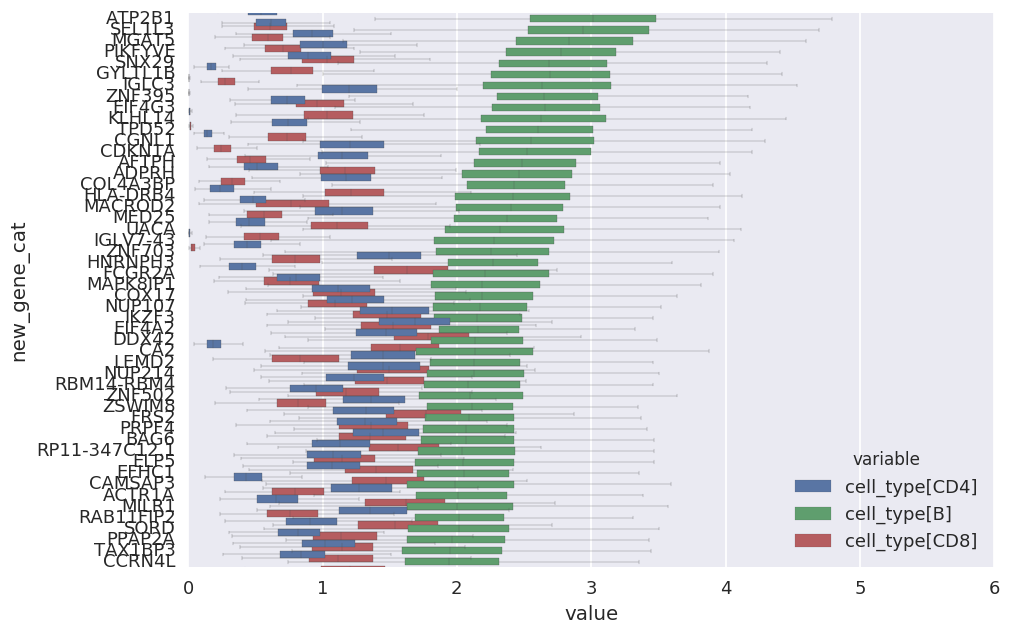

In [13]:
## show theta estimates for first 50 genes, by `sort-by`
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_value_rank_{}'.format(sort_by)] <= 50,:] \
                .sort_values('mean_value_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

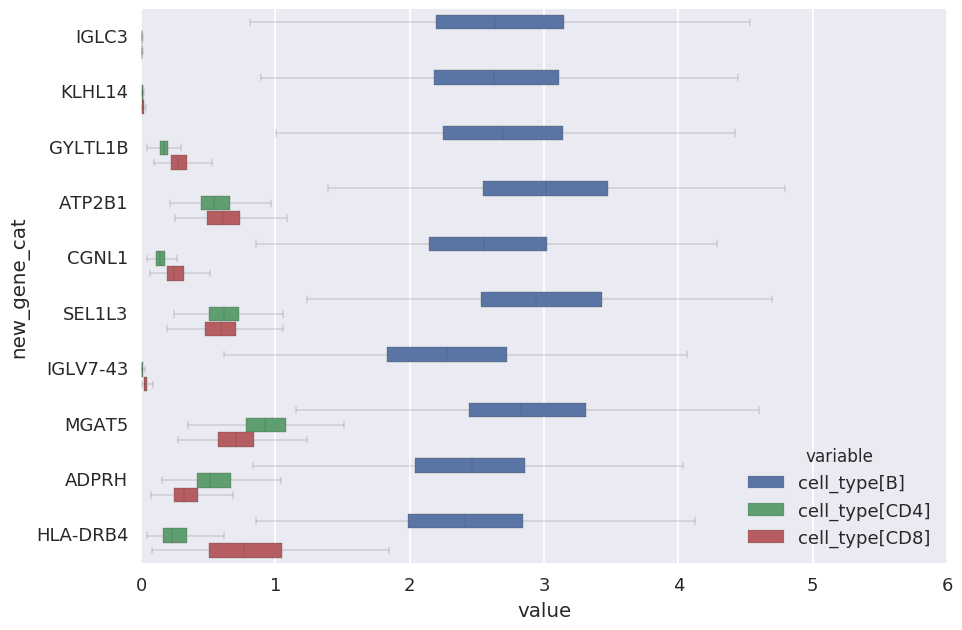

In [14]:
## zoom in on the highest-ranked genes by `sort-by` difference from average 
## across all cell types
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .sort_values('mean_diff_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)

## posterior-predictive checking for selected genes

In [18]:
# get yrep draws
yrep_df = models.prep_yrep_summary(model_fit, sample_df=sample_df, sample_kwds=dict(frac=0.6))

In [16]:
# identify top_genes by name
top_genes = theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .drop_duplicates(subset='new_gene_cat')['new_gene_cat'].values
print(top_genes)

['ADPRH' 'ATP2B1' 'CGNL1' 'GYLTL1B' 'HLA-DRB4' 'IGLC3' 'IGLV7-43' 'KLHL14'
 'MGAT5' 'SEL1L3']


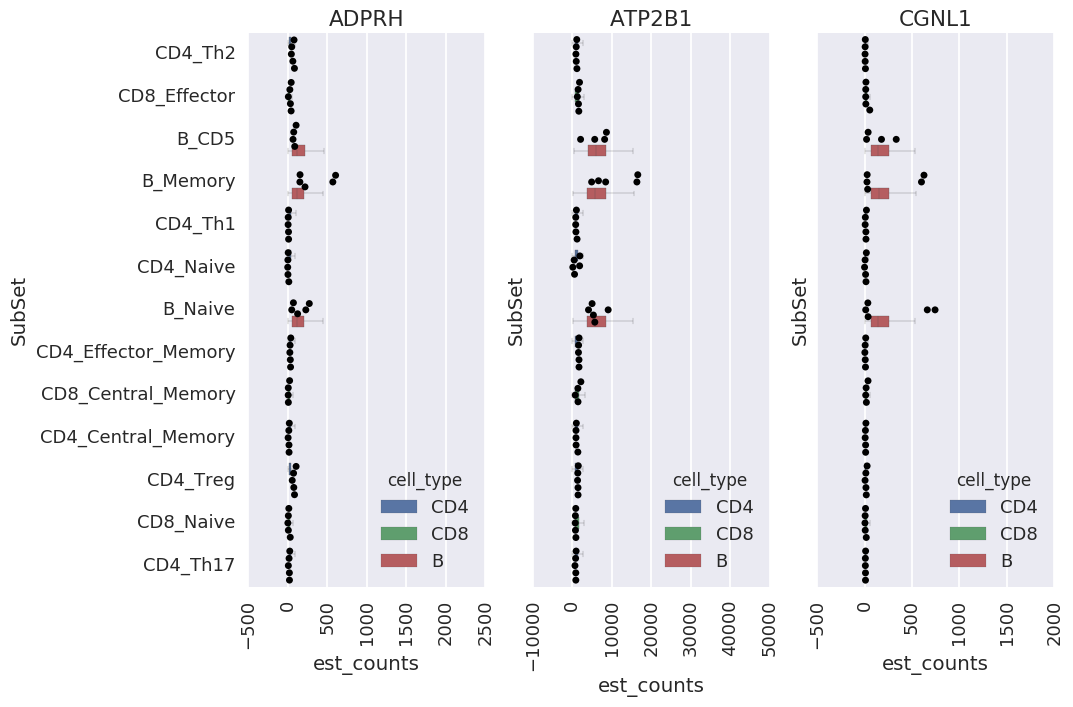

In [17]:
# plot estimates & observed values for top 3 genes, by Subset
with sns.plotting_context('talk'):
    f, axarr = plt.subplots(1, 3, sharey=True)
    a=0
    for gene_name in top_genes[0:3]:
        g = sns.boxplot(data=yrep_df.loc[yrep_df['gene_cat'] == gene_name, :],
                        y='SubSet',
                        hue='cell_type',
                        x='pp_est_counts',
                        ax=axarr[a],
                        fliersize=0, linewidth=0.2)
        sns.swarmplot(data=sample_df.loc[sample_df['gene_cat'] == gene_name, :],
                       y='SubSet', ax=axarr[a],
                       x='est_counts', color='black')
        plt.setp(axarr[a].get_xticklabels(), rotation='vertical')
        axarr[a].set_title(gene_name)
        a = a+1
